In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import struct
import time
import statistics 


In [2]:
class Process:
    def __init__(self,name,arrival_time,burst_time,priority=0):
        self.name=name
        self.arrival_time=arrival_time
        self.burst_time=burst_time
        self.priority=priority
        self.remaining_time=burst_time
        self.start_time= None
        self.end_time=None
        self.waiting_time=None
        self.turnaround_time=None
        self.response_time=None
        self.is_completed=False
        self.is_started = False
        self.state = 'not_started'     # not_started, ready, running, waiting, completed
    
    def complete(self,t):
        self.end_time=t
        self.turnaround_time=self.end_time-self.arrival_time
        self.waiting_time=self.turnaround_time-self.burst_time
        self.is_completed=True
        
    
class Queue:
    def __init__(self,MLFQ,max_burst_time,priority):
        self.max_burst_time = max_burst_time
        self.priority = priority
        self.processes = []
        self.next_queue = None        
        self.last_queue = None
        self.is_completed = True
        self.MLFQ = MLFQ
        self.last = False

    def add_process(self,process):
        self.processes.append(process)
        self.is_completed = False

    def remove_process(self):
        self.processes.pop(0)
        if len(self.processes) == 0:
            self.is_completed = True
        
    def get_process(self):
        return self.processes[0]

    def complete_process(self):
        process = self.get_process()
        process.complete(self.MLFQ.time)
        self.remove_process()       


class MLFQ:    #Multilevel Feedback Queue Scheduling
    def __init__(self,queues,processes,end,i,plot= True):
        self.name = ''
        self.i = i
        for q in queues:
            self.name += str(q)
            self.name += '-'
        self.init_processes(processes)
        self.init_queues(queues)
        self.time = 0
        self.complete_processes = []
        self.n = len(self.processes)
        self.end = end
        self.do_plot = plot

        #-------
        self.arrival_times = [0 for _ in range(end)]
        for p in processes:
            self.arrival_times[p[0]] = p[1]

        self.queues_history = [[] for _ in range(len(queues))]
        self.complete_processes_history = []
        self.avarage_waiting_time = []
        self.avarage_turnaround_time = []
        self.avarage_response_time = []
        self.avarage_burst_time = []


    def init_queues(self,queues):
        self.queues = []
        for q in queues:
            self.add_queue(Queue(self,q,0))

    def add_queue(self,queue):
        if len(self.queues) == 0:
            self.queues.append(queue)
            self.queues[0].last = True
        else:
            self.queues.append(queue)
            self.queues[-1].last = True
            self.queues[-2].last = False
            self.queues[-2].next_queue = queue

    def init_processes(self,processes):
        self.processes = []
        for p in range(len(processes)):
            process = Process(p, processes[p][0],processes[p][1],0)
            self.processes.append(process)

    def check_processes(self):
        if len(self.processes) > 0:
            if self.time >= self.processes[0].arrival_time:
                self.processes[0].state = 'ready'
                self.processes[0].waiting_time = 0
                self.processes[0].response_time = 0
                self.processes[0].turnaround_time = 0
                self.queues[0].add_process(self.processes[0])
                self.processes.pop(0)

    def get_highest_priority_queue(self):
        for queue in self.queues:
            if len(queue.processes) > 0:
                return queue
                
        return None

    def update_processes_times(self):
        for queue in self.queues:
            for process in queue.processes:
                #not started , ready, running, waiting, completed
                if process.state == 'not_started':
                    pass

                elif process.state == 'ready':
                    process.waiting_time += 1
                    process.response_time += 1
                    process.turnaround_time += 1

                elif process.state == 'running':
                    process.remaining_time -= 1
                    process.turnaround_time += 1

                elif process.state == 'waiting':
                    process.waiting_time += 1
                    process.turnaround_time += 1

                elif process.state == 'completed':
                    pass
        

    def run(self):  
        self.current_queue = self.queues[0]
        self.current_process = None
        self.cpu_state = 'free'
        while len(self.complete_processes) != self.n: 
            self.check_processes()
            self.current_queue = self.get_highest_priority_queue()
            if self.current_queue is not None:
                self.cpu_state = 'busy'
                turn_time = 0
                if self.current_queue.last:
                    self.current_process = self.current_queue.get_process()
                    self.current_process.state = 'running'
                    while self.current_process.remaining_time != 0:
                        self.update_processes_times()
                        self.time += 1
                        self.record()

                    self.current_process.state = 'completed'
                    self.current_queue.complete_process()
                    self.complete_processes.append(self.current_process)
                    
                else:
                    self.current_process = self.current_queue.get_process()
                    self.current_process.state = 'running'
                    while turn_time < self.current_queue.max_burst_time:
                        if not self.current_process.is_started:
                            self.current_process.start_time = self.time
                            self.current_process.response_time = self.time - self.current_process.arrival_time
                            self.current_process.is_started = True

                        self.update_processes_times()
                        self.time += 1
                        self.record()
                        if self.current_process.remaining_time == 0:
                            self.current_queue.complete_process()
                            self.current_process.state = 'completed'
                            self.complete_processes.append(self.current_process)
                            self.cpu_state = 'free'
                            break
                        
                        turn_time += 1
                    if not self.current_process.is_completed:
                        self.current_process.state = 'waiting'
                        self.current_queue.next_queue.add_process(self.current_process)
                        self.current_queue.remove_process()
            else:
                self.update_processes_times()
                self.time += 1
                self.record()
                
        if self.do_plot:  self.plot()
        return self.avarage_waiting_time[-1],self.avarage_turnaround_time[-1],self.avarage_response_time[-1],self.avarage_burst_time[-1]
        
    def record(self):
        avarage_waiting_time = 0
        avarage_waiting_time_n = 0
        
        avarage_turnaround_time = 0
        avarage_turnaround_time_n = 0
        
        avarage_response_time = 0
        avarage_response_time_n = 0
        
        avarage_burst_time = 0
        avarage_burst_time_n = 0

        complete_processes_history = len(self.complete_processes)
        for i,queue in enumerate(self.queues):
            self.queues_history[i].append(len(queue.processes))

        self.complete_processes_history.append(len(self.complete_processes))

        for queue in self.queues:
            for process in queue.processes:
                if process.waiting_time != None:
                    avarage_waiting_time += process.waiting_time
                    avarage_waiting_time_n += 1
                if process.turnaround_time != None:
                    avarage_turnaround_time += process.turnaround_time
                    avarage_turnaround_time_n += 1
                if process.response_time != None:
                    avarage_response_time += process.response_time
                    avarage_response_time_n += 1
                if process.burst_time != None:
                    avarage_burst_time += process.burst_time
                    avarage_burst_time_n += 1

        for process in self.complete_processes:
            if process.waiting_time != None:
                avarage_waiting_time += process.waiting_time
                avarage_waiting_time_n += 1
            if process.turnaround_time != None:
                avarage_turnaround_time += process.turnaround_time
                avarage_turnaround_time_n += 1
            if process.response_time != None:
                avarage_response_time += process.response_time
                avarage_response_time_n += 1
            if process.burst_time != None:
                avarage_burst_time += process.burst_time
                avarage_burst_time_n += 1

        if avarage_waiting_time_n != 0:
            self.avarage_waiting_time.append(avarage_waiting_time/avarage_waiting_time_n)
        else:
            self.avarage_waiting_time.append(0)
        if avarage_turnaround_time_n != 0:
            self.avarage_turnaround_time.append(avarage_turnaround_time/avarage_turnaround_time_n)
        else:
            self.avarage_turnaround_time.append(0)
        if avarage_response_time_n != 0:
            self.avarage_response_time.append(avarage_response_time/avarage_response_time_n)
        else:
            self.avarage_response_time.append(0)
        if avarage_burst_time_n != 0:
            self.avarage_burst_time.append(avarage_burst_time/avarage_burst_time_n)
        else:
            self.avarage_burst_time.append(0)
        
    def plot(self):
        print('avarage waiting_time:',self.avarage_waiting_time[-1])
        print('avarage turnaround_time:',self.avarage_turnaround_time[-1])
        print('avarage response_time:',self.avarage_response_time[-1])
        print('avarage burst_time:',self.avarage_burst_time[-1])
        
        plt.figure(figsize=(12,8))
        plt.subplot(4,1,1)
        plt.plot(self.arrival_times,label='burst times')
        plt.legend()
        plt.ylabel('burst time')
        plt.xlabel('time')
        plt.subplot(4,1,2)
        for q in range(len(self.queues)):
            plt.plot(self.queues_history[q],label='Queue '+str(q))
        
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Queue length')
        plt.title('Queue length')

        plt.subplot(4,1,3)
        plt.plot(self.complete_processes_history,label='Processes')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Complete Processes')
        plt.title('Complete Processes')

        plt.subplot(4,1,4)
        plt.plot(self.avarage_waiting_time,label='Waiting time')
        plt.plot(self.avarage_turnaround_time,label='Turnaround time')
        plt.plot(self.avarage_response_time,label='Response time')
        plt.plot(self.avarage_burst_time,label='Burst time')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Time')
        plt.title('Processes')

        plt.savefig('plots/{}{}.png'.format(self.name,self.i))
        plt.show()
        


class Random:
    def __init__(self):
        pass

    def lastbit(sef,f):
        return struct.pack('!f', f)[-1] & 1

    def getrandbits(self,k):
        "Return k random bits using a relative drift of two clocks."
        # assume time.sleep() and time.clock() use different clocks
        # though it might work even if they use the same clock
        #XXX it does not produce "good" random bits, see below for details
        result = 0
        for _ in range(k):
            time.sleep(0)
            result <<= 1
            result |= self.lastbit(time.perf_counter()%100)
        return result

    def randint(self,a, b, n):
        "Return random integer in range [a, b], including both end points."
        res = []
        for _ in range(n):
            res.append(a + self.randbelow(b - a + 1))
        return np.asarray(res)

    def randbelow(self,n):
        "Return a random int in the range [0,n).  Raises ValueError if n<=0."
        # from Lib/random.py
        if n <= 0:
            raise ValueError
        k = n.bit_length()  # don't use (n-1) here because n can be 1
        r = self.getrandbits(k)          # 0 <= r < 2**k
        while r >= n: # avoid skew
            r = self.getrandbits(k)
        return r


        
def generate_process(start,end,number_of_processes,max_burst_time):
    rand = Random() 
    arrival_times = np.random.randint(start,end,number_of_processes)
    burst_times = np.random.randint(1,max_burst_time,number_of_processes)
    arrival_times = np.sort(arrival_times)
    process =  np.array(list((zip(arrival_times,burst_times)))).reshape(number_of_processes,2)
    return process
    
def test_random_generator(l, l_median):  
    runs, n1, n2 = 0, 0, 0
    for i in range(len(l)): 
        if (l[i] >= l_median and l[i-1] < l_median) or (l[i] < l_median and l[i-1] >= l_median): 
            runs += 1  
        if(l[i]) >= l_median: 
            n1 += 1   
        else: 
            n2 += 1   
    runs_exp = ((2*n1*n2)/(n1+n2))+1
    stan_dev = math.sqrt((2*n1*n2*(2*n1*n2-n1-n2))/(((n1+n2)**2)*(n1+n2-1))) 
    z = (runs-runs_exp)/stan_dev 
    return z 

def main(queues,start,end,number_of_processes,max_burst_time,itteration=1,plot=True):
    toltal_scores = np.asarray([0.0,0.0,0.0,0.0])
    waiting_hist = []
    turnaround_hist = []
    response_hist = []
    burst_hist = []

    for itter in range(itteration):
        processes = generate_process(start,end,number_of_processes,max_burst_time)
        mlfq = MLFQ(queues,processes,end,itter,plot)
        temp =  np.asarray(mlfq.run())  
        waiting_hist.append(temp[0])
        turnaround_hist.append(temp[1])
        response_hist.append(temp[2])
        burst_hist.append(temp[3])
        toltal_scores += temp
        
    toltal_scores = toltal_scores/itteration
    print('avarage waiting_time:',toltal_scores[0])
    print('standard deviation waiting_time:',np.std(waiting_hist))
    print('avarage turnaround_time:',toltal_scores[1])
    print('standard deviation turnaround_time:',np.std(turnaround_hist))
    print('avarage response_time:',toltal_scores[2])
    print('standard deviation response_time:',np.std(response_hist))
    print('avarage burst_time:',toltal_scores[3])
    print('standard deviation burst_time:',np.std(burst_hist))

    # mlfq.print_process()

avarage waiting_time: 77.66
avarage turnaround_time: 87.74
avarage response_time: 3.42
avarage burst_time: 10.08


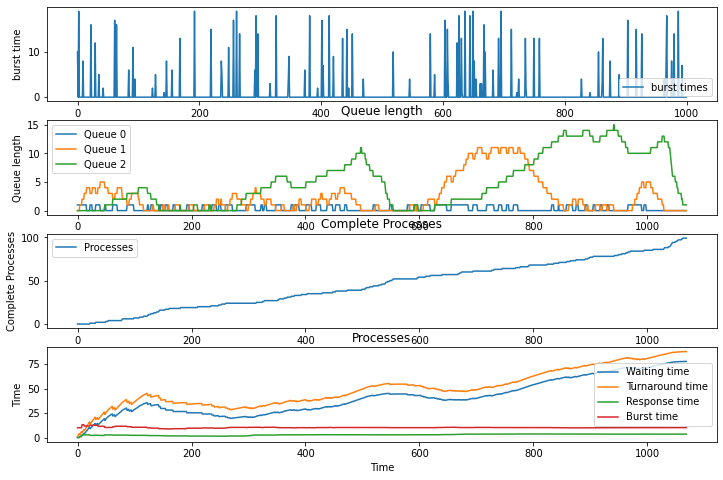

avarage waiting_time: 31.44
avarage turnaround_time: 40.9
avarage response_time: 2.57
avarage burst_time: 9.46


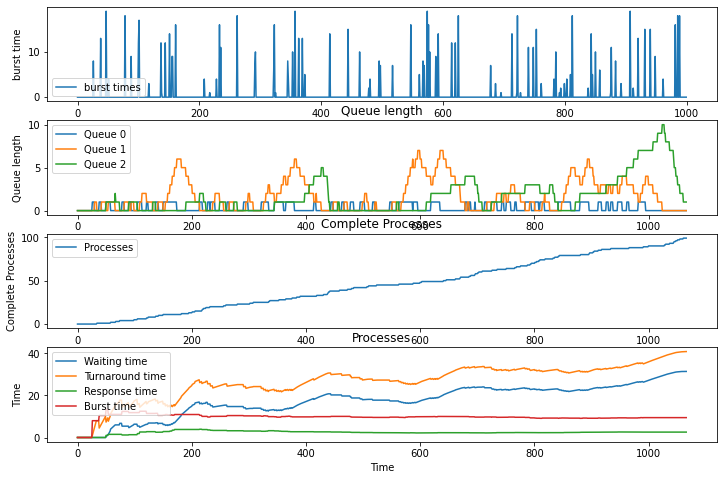

avarage waiting_time: 32.05
avarage turnaround_time: 41.54
avarage response_time: 2.91
avarage burst_time: 9.49


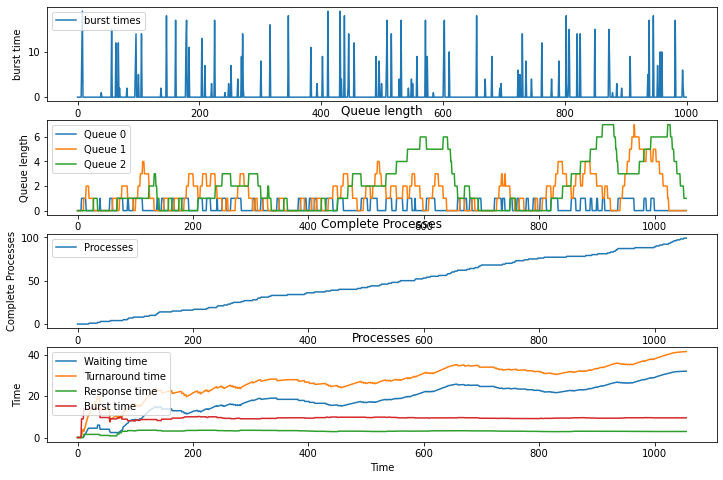

avarage waiting_time: 41.26
avarage turnaround_time: 50.75
avarage response_time: 2.35
avarage burst_time: 9.49


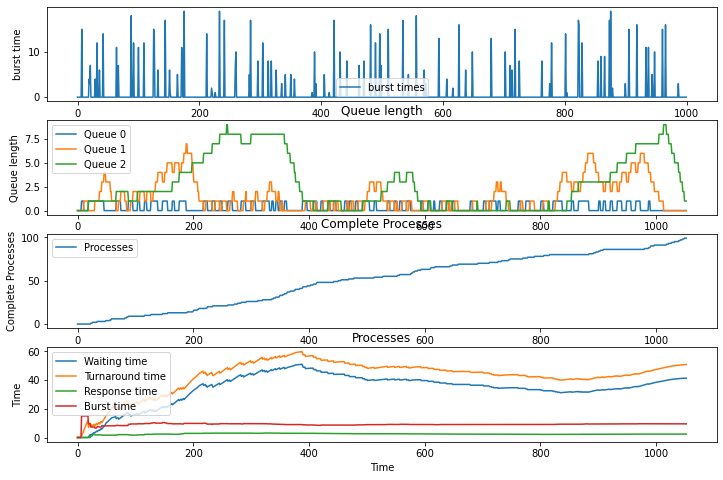

avarage waiting_time: 105.99
avarage turnaround_time: 116.24
avarage response_time: 4.64
avarage burst_time: 10.25


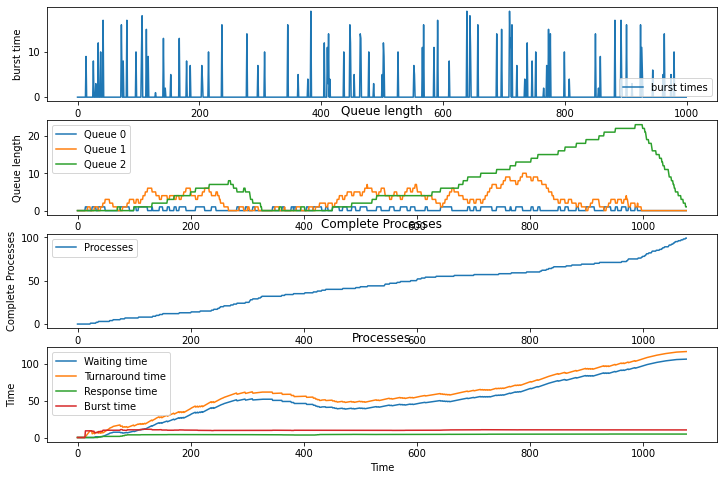

avarage waiting_time: 112.57
avarage turnaround_time: 123.49
avarage response_time: 4.36
avarage burst_time: 10.92


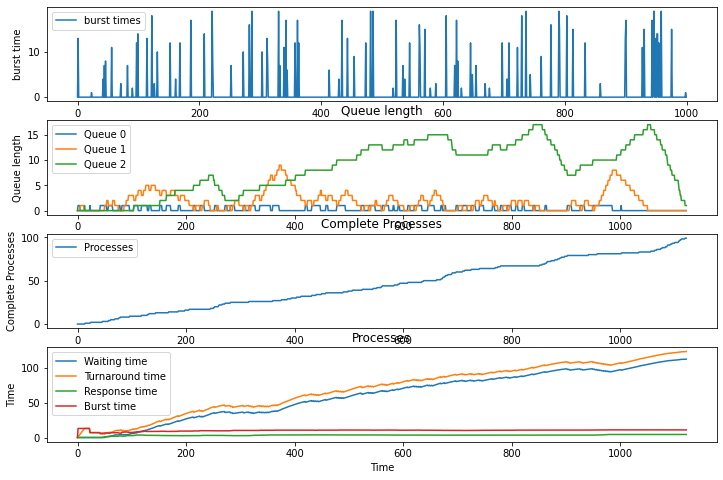

avarage waiting_time: 131.38
avarage turnaround_time: 141.8
avarage response_time: 3.62
avarage burst_time: 10.42


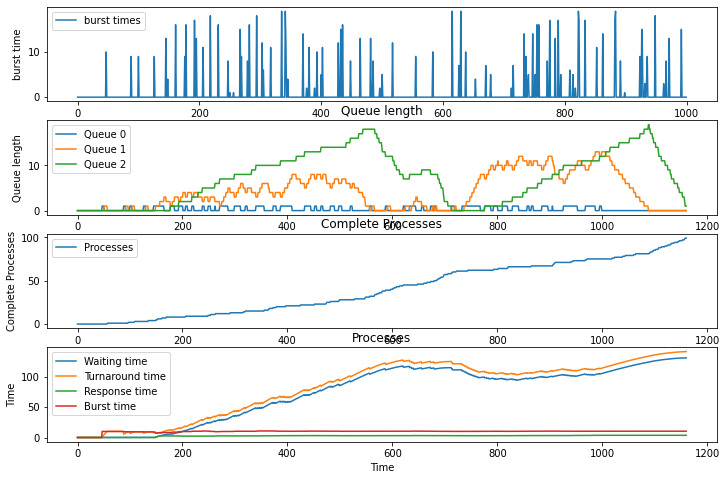

avarage waiting_time: 121.25
avarage turnaround_time: 131.71
avarage response_time: 4.07
avarage burst_time: 10.46


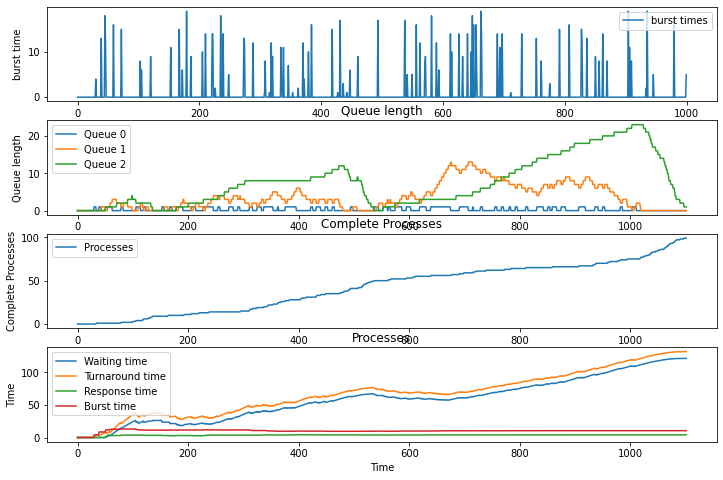

avarage waiting_time: 22.96
avarage turnaround_time: 31.88
avarage response_time: 2.94
avarage burst_time: 8.92


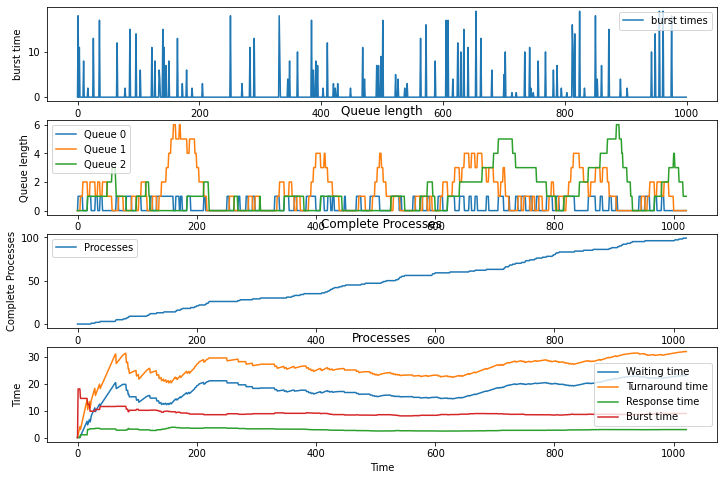

avarage waiting_time: 102.79
avarage turnaround_time: 113.02
avarage response_time: 3.1
avarage burst_time: 10.23


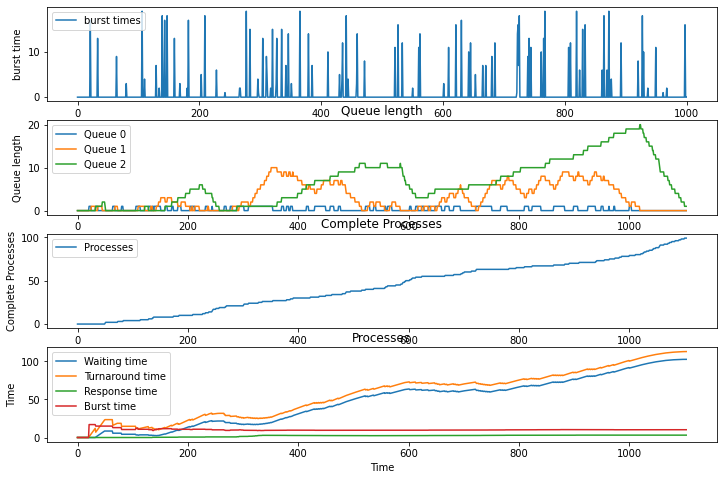

avarage waiting_time: 77.93499999999999
standard deviation waiting_time: 39.964477539434945
avarage turnaround_time: 87.90700000000001
standard deviation turnaround_time: 40.499360254206486
avarage response_time: 3.3980000000000006
standard deviation response_time: 0.7273211120268681
avarage burst_time: 9.972
standard deviation burst_time: 0.5767633830263499


In [3]:
main([4,8,16],0,1000,100,20,itteration=10,plot=1)